**Vertical Strategy: Use text column to predict tex_paragraph column**

**Outline**

1. ✅ filter out stopwords in text column
    - word tokenize text column
2. ✅  use token match in big string to define candidate paragraphs
    - merge overlapping paragraphs
3. ✅ Score/rank paragraphs
    - some terms will be more relevant/weighted than others
    - also score them by requency
4. ✅ Check similarity between predicted paragraphs and actual paragraphs

# Vertical Pipeline: turn vertical strategy into something easily iterable
- like a function callable on an html that returns a nominated paragraph

In [130]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

## Generate parameters from curated training data

### read in the vertical training subset data frame

In [17]:
### read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(2)

In [219]:
### these are the only dkfns that I'm currently working with
print(set(vert_training_subset_df.data_key_friendly_name))

{'Share Repurchase Intention', 'Share Repurchase Authorization', 'Share Repurchase Utilization', 'Unknown Share Repurchase Data'}


In [220]:
relevant_dkfns = list(set(vert_training_subset_df.data_key_friendly_name))
relevant_dkfns

['Share Repurchase Intention',
 'Share Repurchase Authorization',
 'Share Repurchase Utilization',
 'Unknown Share Repurchase Data']

### generate key_tokens from text colum

In [15]:
### compile a string from the text column

text_list = [t.lower() for t in vert_training_subset_df.text]
#print('This is what the text_list looks like: ')
#print("----------------------------")
#print(text_list[0:3])
#print("----------------------------")
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '
#print("")
#print("And now this is what the flattened text_string looks like: ")
#print("----------------------------")
#print(text_string[0:250])
#print("----------------------------")

In [23]:
### tokenize the text string

text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]
#print(no_stops[0:10])

### limit ourselves to the 30 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(30))
key_tokens.columns = ['key_tok', 'kt_count']

can probably improve the above list of key_tokens by using less than 30 terms.... maybe

#### 🤔 I could enhance my key_tokens by doing tf-idf
- between the text column and the the html text - the text column
    - which terms are prominent in text column that are not prominent in the rest of the html
    - which terms are prominent in the noisy signal that are not prominent in the noise?
- I could also enhance it by removing noisy words like 'total'

### define paragraph margins
as the standard deviation of paragraph lengths

In [22]:
par_lengths = [len(par) for par in vert_training_subset_df.paragraph_text]
margin = int(np.std(par_lengths))

### Stage filings to be read in iterably

In [20]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

### for now, isolate only those filings which are in my vertical training df

In [39]:
len(set(vert_training_subset_df.accession_number))

278

In [42]:
len(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))

278

In [47]:
vert_training_subset_filings_list = list(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))
vert_training_subset_filings_list
assert len(vert_training_subset_filings_list) == len(set(vert_training_subset_df.accession_number))

In [106]:
len(vert_training_subset_filings_list)

278

## This will be the beginning of the loop
1. read in a filing
2. call a function that
    - defines candidate paragraphs
    - ranks or scores candidate paragraphs to select top nominee(s)
    - validates if predicted nominee is a good match to actual paragraph in the training csv.

# for now, lets practice on only filings in vertical_training_subset
processing 278 filings from vert_training_subset_filings_list takes about 7 minutes, 45 seconds
- there are lots of optimizations I could do if it becomes necessary

In [172]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []

t0 = datetime.datetime.now()

#for filing in training_filings_list:
#for filing in vert_training_subset_filings_list[0:100]:
for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ################################################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
    #    # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
    #        # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
    #            # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
    #        # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
    #            # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
    #            # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
    #            # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
    #            # note which hit we need to start on for the next iteration of the while loop
                hit = i
    #            # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this only interrupts the nearest parent loop 
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #
    # --------------- store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates down to those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    nominated = candidate_df.cand_par[0]
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    #
    ###############################################################
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    #
    # ⚠️ notice that for expediencey I am only using the first row with a given accession number. (there could be up to 7 rows with the same accession number in the actual csv). The reason for this misalignment is because the primary purpose of this pipeline is to identify paragraphs with target information, it's purpose is not to define up to 7 paragraphs for each filing number.
    actual_paragraph = vert_training_subset_df[vert_training_subset_df.accession_number == an].head(1).paragraph_text
    # 🤔 to enhance this pipeline to work with the original csv I could pick my actual_paragraph to be one with a specific dkfn
    # actual_paragraph = vert_training_subset_df[vert_training_subset_df.accession_number == an and vert_training_subset_df.data_key_friendly_name in relevant_dkfns]
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------
    #print('Actual_paragraph in nom_validatable: ')
    #print('----------', actual_paragraph in nom_validatable)
    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    #print('actual tokens also in nominated_tokens')
    #print('---------- counter = ', counter)
    x = round(100*counter/len(actual_tokens),2)
    #print('that is a ', x, '% inclusion')
    #print("---------------------------------")
    #print("")
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    
    tf = datetime.datetime.now()
    print('finished processing ', len(total_inclusion), 'th filing at ', tf)
    print('process took', tf - ti)
    print("--------------------------")

print("")
print('entire cycle took ', tf - t0)

processing next filing at  2018-06-03 22:42:33.465245


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


finished processing  1 th filing at  2018-06-03 22:42:37.436322
process took 0:00:03.971077
--------------------------
processing next filing at  2018-06-03 22:42:37.436545
finished processing  2 th filing at  2018-06-03 22:42:39.193719
process took 0:00:01.757174
--------------------------
processing next filing at  2018-06-03 22:42:39.193919
finished processing  3 th filing at  2018-06-03 22:42:40.615591
process took 0:00:01.421672
--------------------------
processing next filing at  2018-06-03 22:42:40.615815
finished processing  4 th filing at  2018-06-03 22:42:41.557605
process took 0:00:00.941790
--------------------------
processing next filing at  2018-06-03 22:42:41.558137
finished processing  5 th filing at  2018-06-03 22:42:43.296119
process took 0:00:01.737982
--------------------------
processing next filing at  2018-06-03 22:42:43.296363
finished processing  6 th filing at  2018-06-03 22:42:45.244627
process took 0:00:01.948264
--------------------------
processing next 

finished processing  49 th filing at  2018-06-03 22:43:58.368932
process took 0:00:03.030363
--------------------------
processing next filing at  2018-06-03 22:43:58.369102
finished processing  50 th filing at  2018-06-03 22:43:59.655949
process took 0:00:01.286847
--------------------------
processing next filing at  2018-06-03 22:43:59.656209
finished processing  51 th filing at  2018-06-03 22:44:00.761311
process took 0:00:01.105102
--------------------------
processing next filing at  2018-06-03 22:44:00.761491
finished processing  52 th filing at  2018-06-03 22:44:01.875400
process took 0:00:01.113909
--------------------------
processing next filing at  2018-06-03 22:44:01.875611
finished processing  53 th filing at  2018-06-03 22:44:03.819571
process took 0:00:01.943960
--------------------------
processing next filing at  2018-06-03 22:44:03.819795
finished processing  54 th filing at  2018-06-03 22:44:05.705166
process took 0:00:01.885371
--------------------------
processing

finished processing  97 th filing at  2018-06-03 22:45:13.169192
process took 0:00:01.697989
--------------------------
processing next filing at  2018-06-03 22:45:13.169396
finished processing  98 th filing at  2018-06-03 22:45:14.542695
process took 0:00:01.373299
--------------------------
processing next filing at  2018-06-03 22:45:14.543289
finished processing  99 th filing at  2018-06-03 22:45:15.801278
process took 0:00:01.257989
--------------------------
processing next filing at  2018-06-03 22:45:15.801506
finished processing  100 th filing at  2018-06-03 22:45:17.499567
process took 0:00:01.698061
--------------------------
processing next filing at  2018-06-03 22:45:17.499798
finished processing  101 th filing at  2018-06-03 22:45:18.850305
process took 0:00:01.350507
--------------------------
processing next filing at  2018-06-03 22:45:18.851072
finished processing  102 th filing at  2018-06-03 22:45:19.852745
process took 0:00:01.001673
--------------------------
process

finished processing  144 th filing at  2018-06-03 22:46:31.486259
process took 0:00:02.643777
--------------------------
processing next filing at  2018-06-03 22:46:31.486495
finished processing  145 th filing at  2018-06-03 22:46:32.289839
process took 0:00:00.803344
--------------------------
processing next filing at  2018-06-03 22:46:32.290110
finished processing  146 th filing at  2018-06-03 22:46:32.829389
process took 0:00:00.539279
--------------------------
processing next filing at  2018-06-03 22:46:32.829599
finished processing  147 th filing at  2018-06-03 22:46:34.015839
process took 0:00:01.186240
--------------------------
processing next filing at  2018-06-03 22:46:34.016026
finished processing  148 th filing at  2018-06-03 22:46:35.115538
process took 0:00:01.099512
--------------------------
processing next filing at  2018-06-03 22:46:35.116886
finished processing  149 th filing at  2018-06-03 22:46:36.248417
process took 0:00:01.131531
--------------------------
proc

finished processing  191 th filing at  2018-06-03 22:47:45.189703
process took 0:00:02.623653
--------------------------
processing next filing at  2018-06-03 22:47:45.189903
finished processing  192 th filing at  2018-06-03 22:47:46.195102
process took 0:00:01.005199
--------------------------
processing next filing at  2018-06-03 22:47:46.195340
finished processing  193 th filing at  2018-06-03 22:47:47.797944
process took 0:00:01.602604
--------------------------
processing next filing at  2018-06-03 22:47:47.798105
finished processing  194 th filing at  2018-06-03 22:47:48.697840
process took 0:00:00.899735
--------------------------
processing next filing at  2018-06-03 22:47:48.698016
finished processing  195 th filing at  2018-06-03 22:47:51.678463
process took 0:00:02.980447
--------------------------
processing next filing at  2018-06-03 22:47:51.678749
finished processing  196 th filing at  2018-06-03 22:47:53.635272
process took 0:00:01.956523
--------------------------
proc

finished processing  238 th filing at  2018-06-03 22:49:03.465369
process took 0:00:01.454696
--------------------------
processing next filing at  2018-06-03 22:49:03.465666
finished processing  239 th filing at  2018-06-03 22:49:04.625995
process took 0:00:01.160329
--------------------------
processing next filing at  2018-06-03 22:49:04.626171
finished processing  240 th filing at  2018-06-03 22:49:05.889212
process took 0:00:01.263041
--------------------------
processing next filing at  2018-06-03 22:49:05.889425
finished processing  241 th filing at  2018-06-03 22:49:07.067530
process took 0:00:01.178105
--------------------------
processing next filing at  2018-06-03 22:49:07.067724
finished processing  242 th filing at  2018-06-03 22:49:07.972354
process took 0:00:00.904630
--------------------------
processing next filing at  2018-06-03 22:49:07.972528
finished processing  243 th filing at  2018-06-03 22:49:10.855662
process took 0:00:02.883134
--------------------------
proc

#### examine total_inclusion results (though this is a rather naive metric)

In [173]:
print(total_inclusion)

[False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, True, True, False, True, False, True, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, False, True, True, False, True, False, False, False, False, True, True, True, False, True, False, True, False, False, True, False, False, True, False, False, False, True, False, True, False, True, True, True, True, False, False, False, False, False, True, False, False, False, True, False, False, False, True, True, True, True, False, True, False, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, True, True, False, False, True, True, True, False, True, False, False, False, True, True, False, False, False, False, True, False, True, False, True, False, False, Fal

In [174]:
# total filings processed
len(total_inclusion)

278

In [175]:
# number of actual paragraphs 100% included
np.array(total_inclusion).sum()

108

In [176]:
# total inclusion rate
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')

38.85 % total inclusion


#### examine inclusion_rates (analagous to true positive rate)

In [177]:
# rates of inclusion of actual paragraphs in predicted paragraphs
print(inclusion_rates)

[64.71, 27.27, 100.0, 34.78, 28.57, 11.76, 61.82, 100.0, 63.83, 100.0, 100.0, 35.71, 100.0, 100.0, 36.59, 100.0, 100.0, 65.62, 100.0, 16.33, 100.0, 39.02, 48.21, 0.0, 100.0, 100.0, 47.06, 25.49, 100.0, 93.33, 100.0, 100.0, 66.04, 90.2, 100.0, 100.0, 100.0, 13.21, 100.0, 25.93, 38.1, 100.0, 39.29, 20.0, 100.0, 100.0, 100.0, 97.14, 50.0, 100.0, 100.0, 83.84, 100.0, 25.97, 67.31, 31.25, 56.76, 100.0, 100.0, 100.0, 100.0, 100.0, 10.64, 98.18, 100.0, 54.55, 100.0, 100.0, 34.38, 100.0, 93.1, 54.55, 59.26, 100.0, 43.18, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 78.26, 100.0, 18.75, 47.27, 25.58, 100.0, 76.47, 31.82, 66.67, 100.0, 95.92, 42.86, 47.5, 100.0, 100.0, 100.0, 100.0, 84.38, 100.0, 96.61, 100.0, 100.0, 92.31, 37.04, 100.0, 97.83, 70.89, 31.25, 100.0, 100.0, 83.17, 40.26, 34.92, 35.19, 50.0, 100.0, 47.3, 100.0, 73.53, 100.0, 62.75, 100.0, 98.25, 100.0, 35.29, 100.0, 100.0, 50.0, 100.0, 100.0, 100.0, 100.0, 75.0, 100.0, 71.74, 80.21, 68.75, 100.0, 100.0, 58.33, 42.31, 75.0, 63.41, 100.

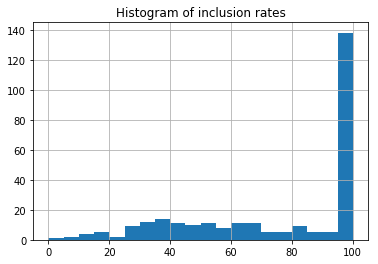

In [178]:
plt.hist(inclusion_rates, bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [179]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

# before I filtered out stop words and non-alphanumeric tokens my inclusion rate was
    # 81.56730215827338
    # this histogram had a hump at the 60% tick and almost nothing below the 40% tick

75.20111510791368

In [180]:
# median inclusion rate
np.median(np.array(inclusion_rates))

# before I filtered out stop words and non-alphanumeric tokens median was
    # 94.285

93.215

#### examine extra_bagage_rate (analagous to false positive rate)

In [187]:
print(extra_baggage_rate)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

[9.66, 12.06, 38.55, 2.36, 8.51, 7.75, 38.04, 23.8, 16.28, 62.86, 31.03, 8.91, 35.8, 52.85, 22.05, 33.85, 51.92, 19.23, 55.26, 4.38, 45.56, 7.95, 20.23, 0.0, 23.16, 28.68, 16.0, 3.23, 14.88, 31.49, 53.94, 25.84, 37.31, 24.88, 23.99, 11.06, 32.09, 4.17, 12.1, 3.6, 6.64, 18.9, 20.56, 6.07, 52.16, 40.69, 58.62, 45.17, 5.53, 25.91, 11.16, 37.38, 35.61, 13.43, 16.9, 8.51, 19.64, 13.58, 28.38, 29.93, 28.62, 20.85, 2.7, 37.43, 16.93, 10.22, 13.19, 34.57, 11.41, 48.71, 32.64, 23.81, 7.76, 37.15, 24.0, 27.74, 41.36, 35.45, 40.96, 40.75, 37.22, 17.77, 20.82, 7.48, 23.89, 3.37, 15.04, 29.6, 21.76, 14.14, 23.91, 45.54, 13.36, 7.65, 14.84, 40.99, 26.66, 33.78, 29.14, 35.07, 30.06, 27.67, 41.7, 24.38, 11.62, 51.8, 34.32, 16.58, 6.04, 15.57, 20.95, 36.49, 13.97, 10.17, 11.28, 9.85, 24.55, 43.99, 41.86, 8.18, 23.77, 21.18, 34.44, 28.46, 43.88, 6.33, 51.29, 15.46, 23.51, 28.32, 25.68, 29.77, 32.26, 19.62, 29.67, 16.55, 66.82, 20.71, 44.24, 45.16, 11.46, 15.94, 23.05, 25.0, 32.34, 8.33, 31.46, 20.4, 47.

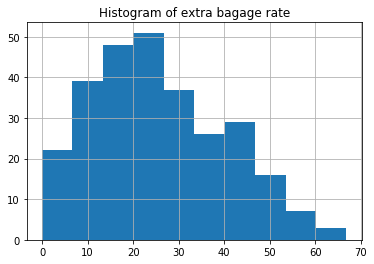

In [192]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

This histogram shows that for the majority of my nominees, 5 - 35% of their tokens are not in the actual tokens. 
- The maximum baggage percentage looks like 65% which means about two thirds of the tokens are extra baggage not found in the actual tokens

#### compare the lengths of the actual paratokens to the nominated paratokens

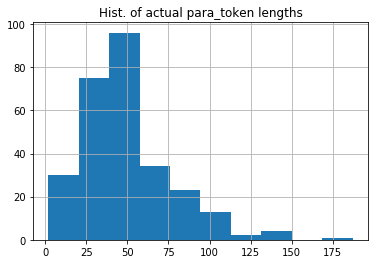

In [182]:
#plt.plot(actu)
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [196]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  49.514388489208635
median 45.5
range 185


**Now lets take a look at the nominated paratokens lengths**

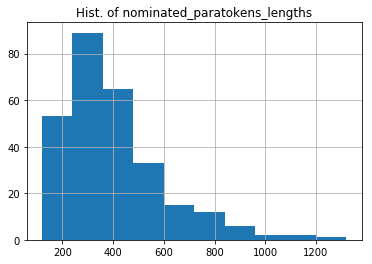

In [183]:
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [197]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))


mean  400.8705035971223
median 353.0
range 1200


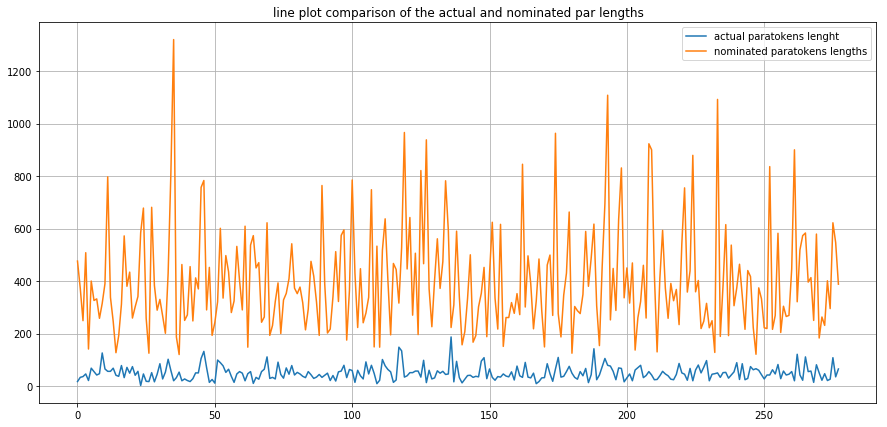

In [213]:
plt.figure(figsize = (15,7))
plt.plot(actual_paratokens_lengths)
plt.plot(nominated_paratokens_lengths)
plt.grid()
plt.title('line plot comparison of the actual and nominated par lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.show()

Hmmm.... It looks like I am definitely including more content than they are. but at least my pipeline has a regular behavior, 
- it's not like it ever includes way to much,
    - at worst it includes about 10 times too much
- and it never includes too little. 

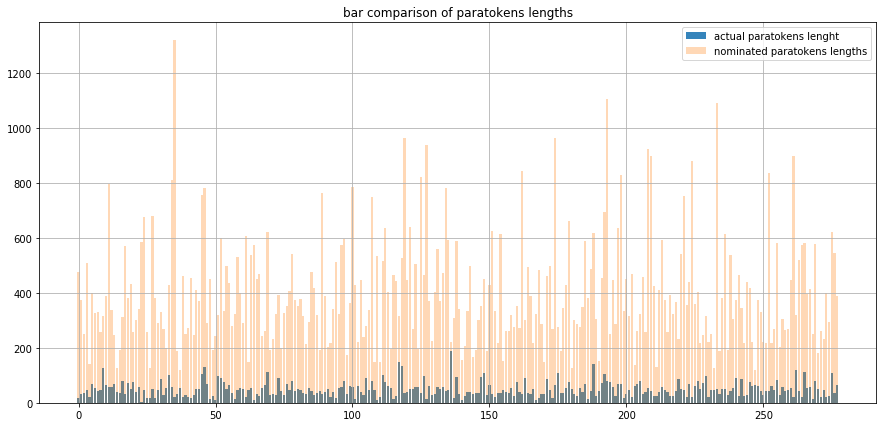

In [218]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.grid()
plt.show()

### For now, ranking paragraphs by something as unrefined as brute length is working well enough
- this success is due to the fact that in my pipeline, length is a function of cluster density
### filtering the candidate paragraphs to those containing 'repurchase' worked well too. 

## 🤔 💡 
#### can enhance by counting how many key_token hits each paragraph has
#### can enhance by assigning weighted values to certain key_tokens

# Just how *good* are my inclusion rates?
- If my nominated paragraphs are excessively long, then they are likely to have high inclusion (both total and partial) merely because they include too much. 
    - if my nominated paragraph was the entire HTML then i would have 100% inclusion

##  Verification Metrics
1. ✅ Inspect the length of my nominated paragraphs. 
    - compare them to the length of the actual paragraphs
        - *Although, don't weight the actual paragraphs too heavily, my confidence in the original csv they gave us has diminished*
            - there is a 25 - 50 % rate of noncorrespondance between a rows text and it's paragraph
            
2. ✅ Improve the inclusion rates by filtering out the stop words before calculating them. (filter out punctuation as well?)
    - If an actual paragraph is 90% stop words then i'm likely to include 90% of it in any sufficiently long arbitrary english language paragraph. 🤦‍♂️ 
    - Also, calculate what % of my nominee paragraphs corresopnd to the overlap with the actual paragraphs (the "center" of the Venn Diagram)
        - and, calculate what percentage corresponds to the content that does not overlap with the actual paragraphs (the nominee's side of the Venn Diagram)

3. ✅ Improve my calculation of total inclusion by ensuring the actual paragraphs don't have too many new line characters.

# Run the "pipeline" on the entire training csv

In [221]:
# read in the csv
share_rprchs_prgrph_df = pd.read_csv('data/share_repurchase_paragraphs.csv')

# Generate parameters from the csv
par_lengths = [len(par) for par in share_rprchs_prgrph_df.paragraph_text]
margin = int(np.std(par_lengths))

# key_tokens.key_tok is already defined above

In [222]:
len(set(share_rprchs_prgrph_df.accession_number))

435

if it took about 8 minutes to process 278 filings
then it should take less than 15 minutes to process 435 🤞 

In [302]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []
filings_not_in_df = [] # track which, if any, filings were not found in the df
no_tokhits_filings = [] # track which filings I failed to find hits for, if any

t0 = datetime.datetime.now()

for filing in training_filings_list:
#for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    #print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ################################################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
    #    # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
    #        # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
    #            # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
    #        # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
    #            # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
    #            # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
    #            # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
    #            # note which hit we need to start on for the next iteration of the while loop
                hit = i
    #            # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this only interrupts the nearest parent loop 
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #
    # --------------- store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates down to those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    if len(candidate_df.cand_par) != 0:
        nominated = candidate_df.cand_par[0]
    elif len(candidate_df.cand_par) == 0:
        # if I failed define a single candidate paragraph
        print('failed to define a single candidate paragraph for filing', filing)
        print('defaulted to using the nominated paragraph from the last filing')
        no_tokhits_filings.append(filing)
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    #
    ###############################################################
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    #
    # ⚠️ notice that for expediencey I am only using the first row with a given accession number. (there could be up to 7 rows with the same accession number in the actual csv). The reason for this misalignment is because the primary purpose of this pipeline is to identify paragraphs with target information, it's purpose is not to define up to 7 paragraphs for each filing number.
    # 🤔 to enhance this pipeline to work with the original csv I could pick my actual_paragraph to be one with a specific dkfn
    #relev_bool_index = [ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(vert_training_subset_df.accession_number, vert_training_subset_df.data_key_friendly_name)]
    if an not in share_rprchs_prgrph_df.accession_number.values:
        print(an, 'was not found in the filings data frame')
        filings_not_in_df.append(an)
        continue
    
    actual_paragraph = share_rprchs_prgrph_df[[ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(share_rprchs_prgrph_df.accession_number, share_rprchs_prgrph_df.data_key_friendly_name)]].head(1).paragraph_text
    # some rows don't have my relevant dkfns and the above assignment creates an empty series
    # so to handle that just pick the first row at random, for now
    if len(actual_paragraph) == 0:
        print('accession number', an, 'did not have a relevant dkfn row in the data frame')
        actual_paragraph = share_rprchs_prgrph_df[share_rprchs_prgrph_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    x = round(100*counter/len(actual_tokens),2)
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    
    tf = datetime.datetime.now()
    print('processed filing', len(total_inclusion), 'at ', tf, '. Process took', tf - ti)
    print("--------------------------")

print("")
print('entire cycle took ', tf - t0)

processing next filing at  2018-06-04 01:11:45.779503


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


finished processing  1 th filing at  2018-06-04 01:11:46.755104
process took 0:00:00.975601
--------------------------
processing next filing at  2018-06-04 01:11:46.755279
finished processing  2 th filing at  2018-06-04 01:11:48.231056
process took 0:00:01.475777
--------------------------
processing next filing at  2018-06-04 01:11:48.231604
finished processing  3 th filing at  2018-06-04 01:11:49.620045
process took 0:00:01.388441
--------------------------
processing next filing at  2018-06-04 01:11:49.620339
finished processing  4 th filing at  2018-06-04 01:11:50.704738
process took 0:00:01.084399
--------------------------
processing next filing at  2018-06-04 01:11:50.704921
finished processing  5 th filing at  2018-06-04 01:11:51.987998
process took 0:00:01.283077
--------------------------
processing next filing at  2018-06-04 01:11:51.988737
finished processing  6 th filing at  2018-06-04 01:11:52.837576
process took 0:00:00.848839
--------------------------
processing next 

finished processing  46 th filing at  2018-06-04 01:12:58.533206
process took 0:00:00.604452
--------------------------
processing next filing at  2018-06-04 01:12:58.533473
finished processing  47 th filing at  2018-06-04 01:13:02.088009
process took 0:00:03.554536
--------------------------
processing next filing at  2018-06-04 01:13:02.088188
finished processing  48 th filing at  2018-06-04 01:13:03.332826
process took 0:00:01.244638
--------------------------
processing next filing at  2018-06-04 01:13:03.333018
finished processing  49 th filing at  2018-06-04 01:13:05.142981
process took 0:00:01.809963
--------------------------
processing next filing at  2018-06-04 01:13:05.143570
finished processing  50 th filing at  2018-06-04 01:13:06.340994
process took 0:00:01.197424
--------------------------
processing next filing at  2018-06-04 01:13:06.342172
finished processing  51 th filing at  2018-06-04 01:13:07.694395
process took 0:00:01.352223
--------------------------
processing

finished processing  92 th filing at  2018-06-04 01:14:15.593447
process took 0:00:02.098853
--------------------------
processing next filing at  2018-06-04 01:14:15.593662
finished processing  93 th filing at  2018-06-04 01:14:17.178051
process took 0:00:01.584389
--------------------------
processing next filing at  2018-06-04 01:14:17.178225
finished processing  94 th filing at  2018-06-04 01:14:18.878670
process took 0:00:01.700445
--------------------------
processing next filing at  2018-06-04 01:14:18.879028
finished processing  95 th filing at  2018-06-04 01:14:20.863050
process took 0:00:01.984022
--------------------------
processing next filing at  2018-06-04 01:14:20.863254
finished processing  96 th filing at  2018-06-04 01:14:22.667393
process took 0:00:01.804139
--------------------------
processing next filing at  2018-06-04 01:14:22.667579
finished processing  97 th filing at  2018-06-04 01:14:24.642105
process took 0:00:01.974526
--------------------------
processing

finished processing  138 th filing at  2018-06-04 01:15:36.211230
process took 0:00:01.542524
--------------------------
processing next filing at  2018-06-04 01:15:36.211492
finished processing  139 th filing at  2018-06-04 01:15:37.600885
process took 0:00:01.389393
--------------------------
processing next filing at  2018-06-04 01:15:37.601080
finished processing  140 th filing at  2018-06-04 01:15:38.498499
process took 0:00:00.897419
--------------------------
processing next filing at  2018-06-04 01:15:38.498719
finished processing  141 th filing at  2018-06-04 01:15:39.395022
process took 0:00:00.896303
--------------------------
processing next filing at  2018-06-04 01:15:39.395207
finished processing  142 th filing at  2018-06-04 01:15:41.626338
process took 0:00:02.231131
--------------------------
processing next filing at  2018-06-04 01:15:41.626604
finished processing  143 th filing at  2018-06-04 01:15:42.878826
process took 0:00:01.252222
--------------------------
proc

finished processing  183 th filing at  2018-06-04 01:16:47.795929
process took 0:00:01.800330
--------------------------
processing next filing at  2018-06-04 01:16:47.796108
finished processing  184 th filing at  2018-06-04 01:16:49.097235
process took 0:00:01.301127
--------------------------
processing next filing at  2018-06-04 01:16:49.097486
accession number 0000277135-18-000007 did not have a relevant dkfn row in the data frame
finished processing  185 th filing at  2018-06-04 01:16:49.700110
process took 0:00:00.602624
--------------------------
processing next filing at  2018-06-04 01:16:49.700366
finished processing  186 th filing at  2018-06-04 01:16:51.839509
process took 0:00:02.139143
--------------------------
processing next filing at  2018-06-04 01:16:51.839722
finished processing  187 th filing at  2018-06-04 01:16:52.776771
process took 0:00:00.937049
--------------------------
processing next filing at  2018-06-04 01:16:52.777766
finished processing  188 th filing a

finished processing  229 th filing at  2018-06-04 01:18:10.195354
process took 0:00:01.000038
--------------------------
processing next filing at  2018-06-04 01:18:10.195568
finished processing  230 th filing at  2018-06-04 01:18:12.035241
process took 0:00:01.839673
--------------------------
processing next filing at  2018-06-04 01:18:12.035504
finished processing  231 th filing at  2018-06-04 01:18:14.535580
process took 0:00:02.500076
--------------------------
processing next filing at  2018-06-04 01:18:14.535770
finished processing  232 th filing at  2018-06-04 01:18:16.451058
process took 0:00:01.915288
--------------------------
processing next filing at  2018-06-04 01:18:16.451295
finished processing  233 th filing at  2018-06-04 01:18:17.528060
process took 0:00:01.076765
--------------------------
processing next filing at  2018-06-04 01:18:17.528309
finished processing  234 th filing at  2018-06-04 01:18:18.891768
process took 0:00:01.363459
--------------------------
proc

finished processing  273 th filing at  2018-06-04 01:19:26.378289
process took 0:00:01.512783
--------------------------
processing next filing at  2018-06-04 01:19:26.378539
finished processing  274 th filing at  2018-06-04 01:19:27.504117
process took 0:00:01.125578
--------------------------
processing next filing at  2018-06-04 01:19:27.504353
finished processing  275 th filing at  2018-06-04 01:19:27.828416
process took 0:00:00.324063
--------------------------
processing next filing at  2018-06-04 01:19:27.828659
finished processing  276 th filing at  2018-06-04 01:19:29.504060
process took 0:00:01.675401
--------------------------
processing next filing at  2018-06-04 01:19:29.504240
finished processing  277 th filing at  2018-06-04 01:19:30.656557
process took 0:00:01.152317
--------------------------
processing next filing at  2018-06-04 01:19:30.657590
finished processing  278 th filing at  2018-06-04 01:19:31.995943
process took 0:00:01.338353
--------------------------
proc

finished processing  320 th filing at  2018-06-04 01:20:44.557186
process took 0:00:01.215191
--------------------------
processing next filing at  2018-06-04 01:20:44.557433
finished processing  321 th filing at  2018-06-04 01:20:45.878995
process took 0:00:01.321562
--------------------------
processing next filing at  2018-06-04 01:20:45.879201
finished processing  322 th filing at  2018-06-04 01:20:47.396821
process took 0:00:01.517620
--------------------------
processing next filing at  2018-06-04 01:20:47.397083
finished processing  323 th filing at  2018-06-04 01:20:49.358327
process took 0:00:01.961244
--------------------------
processing next filing at  2018-06-04 01:20:49.358506
finished processing  324 th filing at  2018-06-04 01:20:50.606234
process took 0:00:01.247728
--------------------------
processing next filing at  2018-06-04 01:20:50.606416
finished processing  325 th filing at  2018-06-04 01:20:51.940220
process took 0:00:01.333804
--------------------------
proc

finished processing  366 th filing at  2018-06-04 01:22:07.301906
process took 0:00:01.210061
--------------------------
processing next filing at  2018-06-04 01:22:07.302100
accession number 0000320335-18-000006 did not have a relevant dkfn row in the data frame
finished processing  367 th filing at  2018-06-04 01:22:09.227280
process took 0:00:01.925180
--------------------------
processing next filing at  2018-06-04 01:22:09.227455
finished processing  368 th filing at  2018-06-04 01:22:11.929654
process took 0:00:02.702199
--------------------------
processing next filing at  2018-06-04 01:22:11.929923
finished processing  369 th filing at  2018-06-04 01:22:13.373574
process took 0:00:01.443651
--------------------------
processing next filing at  2018-06-04 01:22:13.373780
finished processing  370 th filing at  2018-06-04 01:22:14.827750
process took 0:00:01.453970
--------------------------
processing next filing at  2018-06-04 01:22:14.828037
finished processing  371 th filing a

finished processing  410 th filing at  2018-06-04 01:23:28.074919
process took 0:00:01.118345
--------------------------
processing next filing at  2018-06-04 01:23:28.075097
finished processing  411 th filing at  2018-06-04 01:23:29.106500
process took 0:00:01.031403
--------------------------
processing next filing at  2018-06-04 01:23:29.106696
finished processing  412 th filing at  2018-06-04 01:23:30.251843
process took 0:00:01.145147
--------------------------
processing next filing at  2018-06-04 01:23:30.252020
finished processing  413 th filing at  2018-06-04 01:23:31.389102
process took 0:00:01.137082
--------------------------
processing next filing at  2018-06-04 01:23:31.389405
finished processing  414 th filing at  2018-06-04 01:23:32.457572
process took 0:00:01.068167
--------------------------
processing next filing at  2018-06-04 01:23:32.457938
finished processing  415 th filing at  2018-06-04 01:23:33.796302
process took 0:00:01.338364
--------------------------
proc

In [303]:
# were there any filings I failed to find a single hit for?
print(len(no_tokhits_filings))

1


In [304]:
# were there any filings not found in the dataframe?
print(len(filings_not_in_df))

0


In [305]:
# examine the total_inclusion results (even if it's a naive metric)

In [306]:
#len(total)
print(len(total_inclusion), 'total filings processed')
print(np.array(total_inclusion).sum(), 'number of paragraphs 100% included')
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')
print("")

435 total filings processed
171 number of paragraphs 100% included
39.31 % total inclusion



In [307]:
# examine the inclusion rates (like true positive rate)

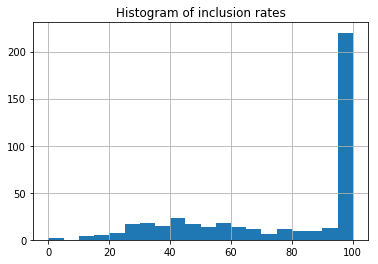

In [308]:
plt.hist(inclusion_rates , bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [309]:
# mean inclusion rate# mean in 
np.mean(np.array(inclusion_rates))

76.10880459770115

In [310]:
# median inclusion rate
np.median(np.array(inclusion_rates)) 
# 50 % of the actual paragraphs have an inclusion rate of at least

95.83

In [326]:
# 70% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 30)

56.83599999999999

In [325]:
# 75 % of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 25)

50.0

In [327]:
# 90% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 10)

32.454

In [311]:
# examine the extra_bagage_rate (like false positive rate, sorta)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

----------------
mean bagage rate:  26.247977011494253
median bagage rate:  25.0



In [333]:
np.percentile(extra_baggage_rate, 70)
# only 30% of my nominees have a bagage rate of at least?

33.29199999999998

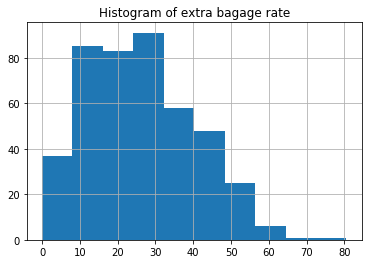

In [312]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

In [313]:
# compare the lengths of the actual paratokens to the nominated paratokens

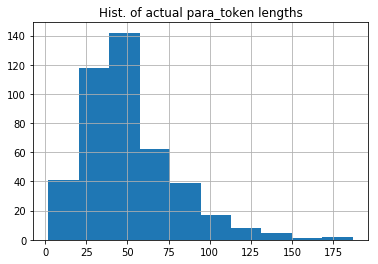

In [314]:
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [315]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  51.11724137931034
median 46.0
range 185


In [316]:
# now lets look at the nominated paratokens lengths

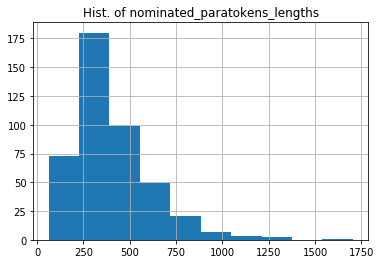

In [317]:
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [318]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

mean  406.19310344827585
median 355.0
range 1642


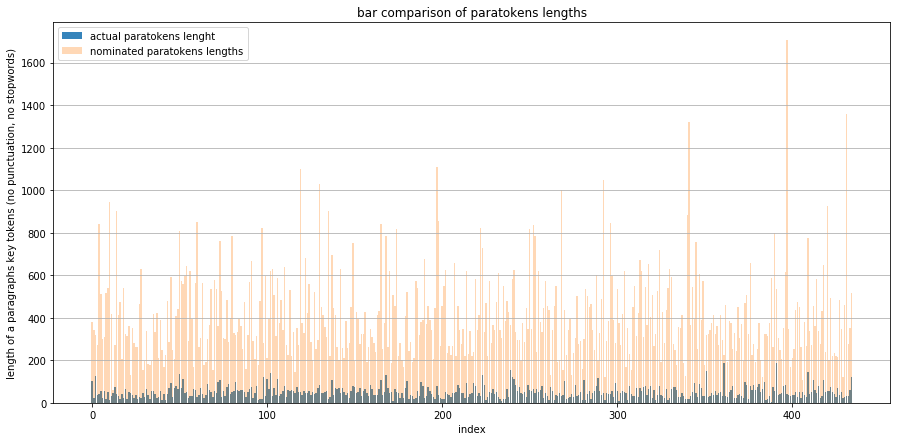

In [336]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.xlabel('index')
plt.ylabel('length of a paragraphs key tokens (no punctuation, no stopwords)')
plt.grid(axis = 'y')
plt.show()